## Import TensorFlow and other libraries

In [1]:
import load 
import outils
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
df = outils.Load_data()

In [3]:
df = df.load_object("dataset2.zip")

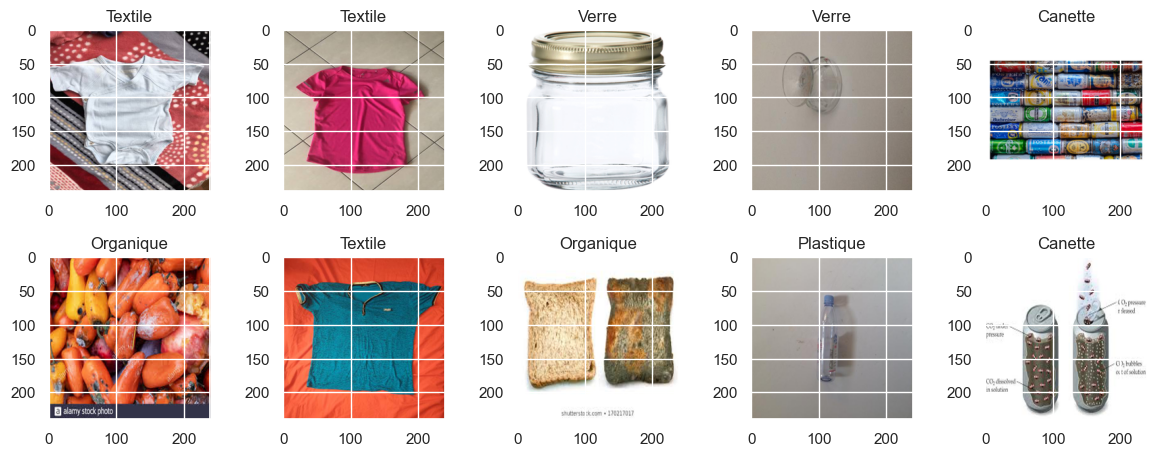

In [4]:
df.plot()

In [6]:
df.encodage()

In [10]:
(X_train, y_train), (X_test, y_test) = df.create_data(test_size=0.001)

In [7]:
print(f"X_train shape : {X_train.shape}")
print(f"X_test  shape : {X_test.shape}")

X_train shape : (12125, 240, 240, 3)
X_test  shape : (13, 240, 240, 3)


In [14]:
X_train = X_train[20:100]

In [16]:
X_train.shape

(80, 240, 240, 3)

In [18]:
X_train = X_train.astype('float32') / 255.

In [20]:
X_test = X_test.astype('float32') / 255.

In [8]:
#noise_adder = outils.NoiseAdder(X_train)

In [10]:
#noisy_gaussian = noise_adder.apply("gaussian", std=0.2)

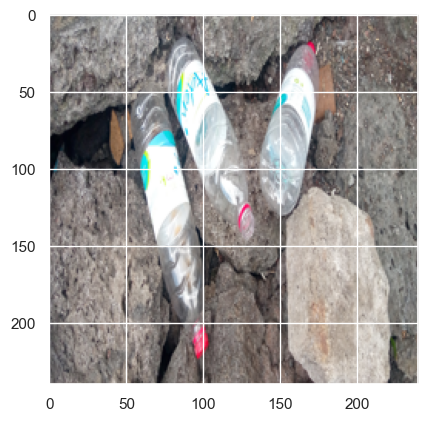

In [10]:
plt.imshow(X_test[8])

In [22]:
print(f"min = {np.min(X_test)} et max = {np.max(X_test)}")

min = 0.0 et max = 1.0


In [24]:
print(f"min = {np.min(X_train)} et max = {np.max(X_train)}")

min = 0.0 et max = 1.0


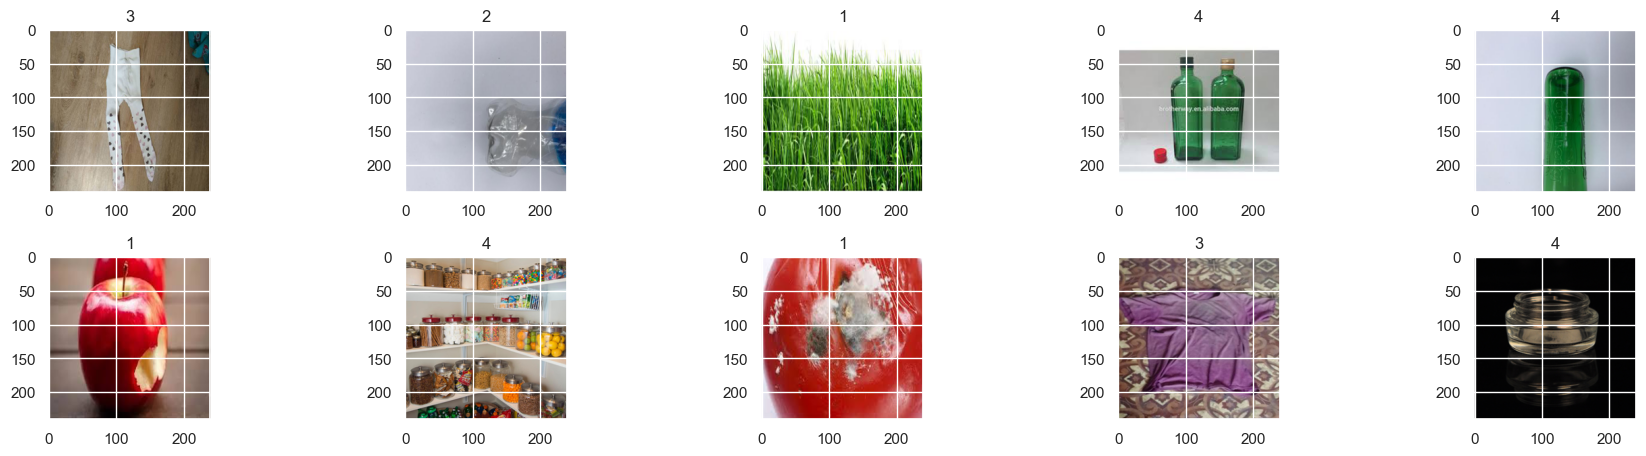

In [13]:
plt.figure(figsize=(18,9))
for i in range(1,11):
    plt.subplot(4,5,i)
    plt.imshow(X_train[i])
    plt.title(y_train[i])
    plt.tight_layout()
plt.show()

In [2]:
import os 
import numpy as np
import tensorflow as tf 
from tensorflow.keras import layers, models, losses, callbacks, regularizers
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import LearningRateScheduler,ModelCheckpoint,ReduceLROnPlateau

In [9]:
from keras.saving import register_keras_serializable

In [36]:
def ResidualBlock(filters, stride=1, use_bn=True, l2=1e-4):
    def f(x):
        shortcut = x
        y = layers.Conv2D(filters, 3, strides=stride, padding="same",
                          kernel_regularizer=tf.keras.regularizers.l2(l2), use_bias=not use_bn)(x)
        if use_bn: y = layers.BatchNormalization()(y)
        y = layers.Activation("relu")(y)

        y = layers.Conv2D(filters, 3, padding="same",
                          kernel_regularizer=tf.keras.regularizers.l2(l2), use_bias=not use_bn)(y)
        if use_bn: y = layers.BatchNormalization()(y)

        # Adapter raccourci
        if shortcut.shape[-1] != filters or stride != 1:
            shortcut = layers.Conv2D(filters, 1, strides=stride, padding="same",
                                     kernel_regularizer=tf.keras.regularizers.l2(l2),
                                     use_bias=not use_bn)(shortcut)
            if use_bn: shortcut = layers.BatchNormalization()(shortcut)

        out = layers.Add()([y, shortcut])
        out = layers.Activation("relu")(out)
        return out
    return f


# -----------------------------
# Bloc résiduel upsampling
# -----------------------------
def ResidualBlockUp(filters, scale=2, use_bn=True, l2=1e-4):
    def f(x):
        shortcut = x
        y = layers.UpSampling2D(size=(scale, scale))(x)
        y = layers.Conv2D(filters, 3, padding="same",
                          kernel_regularizer=tf.keras.regularizers.l2(l2), use_bias=not use_bn)(y)
        if use_bn: y = layers.BatchNormalization()(y)
        y = layers.Activation("relu")(y)

        y = layers.Conv2D(filters, 3, padding="same",
                          kernel_regularizer=tf.keras.regularizers.l2(l2), use_bias=not use_bn)(y)
        if use_bn: y = layers.BatchNormalization()(y)

        shortcut = layers.UpSampling2D(size=(scale, scale))(shortcut)
        shortcut = layers.Conv2D(filters, 1, padding="same",
                                 kernel_regularizer=tf.keras.regularizers.l2(l2),
                                 use_bias=not use_bn)(shortcut)
        if use_bn: shortcut = layers.BatchNormalization()(shortcut)

        out = layers.Add()([y, shortcut])
        out = layers.Activation("relu")(out)
        return out
    return f


# -----------------------------
# Échantillonnage
# -----------------------------
@register_keras_serializable()
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_logvar = inputs
        eps = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_logvar) * eps


# -----------------------------
def build_encoder(input_shape=(240, 240, 3), latent_dim=128, base=32):
    inp = layers.Input(shape=input_shape)
    x = inp

    # downsampling avec blocs résiduels
    x = layers.Conv2D(base, 3, padding="same")(x)
    x = layers.Activation("relu")(x)

    x = ResidualBlock(base,   stride=1)(x)  # HxW
    x = ResidualBlock(base*2, stride=2)(x)  # H/2 x W/2
    x = ResidualBlock(base*2, stride=1)(x)
    x = ResidualBlock(base*4, stride=2)(x)  # H/4 x W/4
    x = ResidualBlock(base*4, stride=1)(x)
    x = ResidualBlock(base*8, stride=2)(x)  # H/8 x W/8
    x = ResidualBlock(base*8, stride=1)(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(2*latent_dim, activation="relu")(x)

    z_mean   = layers.Dense(latent_dim, name="z_mean")(x)
    z_logvar = layers.Dense(latent_dim, name="z_logvar")(x)
    z = Sampling()([z_mean, z_logvar])

    return tf.keras.Model(inp, [z_mean, z_logvar, z], name="encoder")

def build_decoder(output_shape=(240, 240, 3), latent_dim=128, base=32):
    H, W, C = output_shape
    # Taille de départ (doit être un diviseur de H,W après 3 downsamples → H/8,W/8)
    h0, w0 = H // 8, W // 8
    inp = layers.Input(shape=(latent_dim,))
    x = layers.Dense(h0 * w0 * base*8, activation="relu")(inp)
    x = layers.Reshape((h0, w0, base*8))(x)

    x = ResidualBlock(base*8, stride=1)(x)
    x = ResidualBlockUp(base*4)(x)  # H/4
    x = ResidualBlock(base*4, stride=1)(x)
    x = ResidualBlockUp(base*2)(x)  # H/2
    x = ResidualBlock(base*2, stride=1)(x)
    x = ResidualBlockUp(base)(x)    # H
    x = ResidualBlock(base, stride=1)(x)

    # Sortie dans [0,1] via sigmoid
    out = layers.Conv2D(C, 3, padding="same", activation="sigmoid")(x)
    return tf.keras.Model(inp, out, name="decoder")


# -----------------------------
# Callback pour affichage reconstruction
# -----------------------------
class PlotReconstructionCallback(tf.keras.callbacks.Callback):
    def __init__(self, model, x_vis):
        super().__init__()
        self.vae_model = model
        self.x_vis = x_vis#.astype("float32") / 255.0  # normalisation ici

    def on_epoch_end(self, epoch, logs=None):
        z_mean, z_logvar, z = self.vae_model.encoder.predict(self.x_vis)
        recon = self.vae_model.decoder.predict(z)
        n = min(5, len(self.x_vis))
        plt.figure(figsize=(20, 8))
        for i in range(n):
            plt.subplot(2, n, i + 1)
            plt.imshow(np.clip(self.x_vis[i], 0, 1))
            plt.axis("off")
            plt.title("Original")

            plt.subplot(2, n, n + i + 1)
            plt.imshow(np.clip(recon[i], 0, 1))
            plt.axis("off")
            plt.title("Reconstruit")
        plt.suptitle(f"Époque {epoch + 1}")
        plt.tight_layout()
        plt.show()


# -----------------------------
# Classe ResidualVAE β-VAE
# -----------------------------
@register_keras_serializable()
class ResidualVAE(tf.keras.Model):
    def __init__(self, encoder, decoder, beta=0.001, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta

        self.total_loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.recon_loss_tracker = tf.keras.metrics.Mean(name="recon_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")
    def get_config(self):
        config = super().get_config()
        config.update({
            "beta": self.beta,
            # encoder et decoder doivent aussi être sérialisés
            "encoder": tf.keras.utils.serialize_keras_object(self.encoder),
            "decoder": tf.keras.utils.serialize_keras_object(self.decoder),
        })
        return config

    @classmethod
    def from_config(cls, config):
        encoder = tf.keras.utils.deserialize_keras_object(config.pop("encoder"))
        decoder = tf.keras.utils.deserialize_keras_object(config.pop("decoder"))
        return cls(encoder=encoder, decoder=decoder, **config)

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.recon_loss_tracker,
            self.kl_loss_tracker,
        ]
    def call(self, inputs):
        _, _, z = self.encoder(inputs)
        return self.decoder(z)
        
    def train_step(self, data):
        x = data[0] if isinstance(data, (tuple, list)) else data
        #x = tf.cast(x, tf.float32) / 255.0  # normalisation

        with tf.GradientTape() as tape:
            z_mean, z_logvar, z = self.encoder(x, training=True)
            x_hat = self.decoder(z, training=True)

            # BCE reconstruction loss
            recon_loss = tf.reduce_mean(
                tf.reduce_sum(tf.keras.losses.binary_crossentropy(x, x_hat), axis=(1, 2))
            )

            # KL divergence
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(
                    1 + z_logvar - tf.square(z_mean) - tf.exp(z_logvar), axis=1
                )
            )

            total_loss = recon_loss + self.beta * kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.recon_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "recon_loss": self.recon_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        x = data[0] if isinstance(data, (tuple, list)) else data
        #x = tf.cast(x, tf.float32) / 255.0

        z_mean, z_logvar, z = self.encoder(x, training=False)
        x_hat = self.decoder(z, training=False)

        recon_loss = tf.reduce_mean(
            tf.reduce_sum(tf.keras.losses.binary_crossentropy(x, x_hat), axis=(1, 2))
        )

        kl_loss = -0.5 * tf.reduce_mean(
            tf.reduce_sum(1 + z_logvar - tf.square(z_mean) - tf.exp(z_logvar), axis=1)
        )

        total_loss = recon_loss + self.beta * kl_loss

        self.total_loss_tracker.update_state(total_loss)
        self.recon_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "recon_loss": self.recon_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def train(
        self, x_train, x_val=None, batch_size=32, epochs=100, x_vis=None, save_path="residual_vae.keras"
    ):
        self.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))

        callbacks_list = [
            tf.keras.callbacks.EarlyStopping(
                monitor="val_loss", patience=30, restore_best_weights=True
            ),
            tf.keras.callbacks.ModelCheckpoint(save_path, save_best_only=True),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor="val_loss", factor=0.5, patience=10, verbose=1, min_lr=1e-6
            ),
        ]

        if x_vis is not None:
            callbacks_list.append(PlotReconstructionCallback(self, x_vis))

        history = self.fit(
            x_train, x_train,
            validation_data=(x_val, x_val) if x_val is not None else None,
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks_list,
            shuffle=True,
        )
        return history


In [24]:
input_shape = (240, 240, 3)   # adapter à vos images
latent_dim  = 128

encoder = build_encoder(input_shape=input_shape, latent_dim=latent_dim, base=32)
decoder = build_decoder(output_shape=input_shape, latent_dim=latent_dim, base=32)
autoencoder = ResidualVAE(encoder, decoder,beta=0.01)

In [25]:
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)    │ (None, 240, 240, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_72 (Conv2D)            │ (None, 240, 240, 32)      │             896 │ input_layer_4[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_58 (Activation)    │ (None, 240, 240, 32)      │               0 │ conv2d_72[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_73 (Conv2D)            │ (None, 240, 240, 32)      │           9,216 │ activation_58[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_68        │ (None, 240, 240, 32)      │             128 │ conv2d_73[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_59 (Activation)    │ (None, 240, 240, 32)      │               0 │ batch_normalization_68[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_74 (Conv2D)            │ (None, 240, 240, 32)      │           9,216 │ activation_59[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_69        │ (None, 240, 240, 32)      │             128 │ conv2d_74[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_28 (Add)                  │ (None, 240, 240, 32)      │               0 │ batch_normalization_69[0]… │
│                               │                           │                 │ activation_58[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_60 (Activation)    │ (None, 240, 240, 32)      │               0 │ add_28[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_75 (Conv2D)            │ (None, 120, 120, 64)      │          18,432 │ activation_60[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_70        │ (None, 120, 120, 64)      │             256 │ conv2d_75[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_61 (Activation)    │ (None, 120, 120, 64)      │               0 │ batch_normalization_70[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_76 (Conv2D)            │ (None, 120, 120, 64)      │          36,864 │ activation_61[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_77 (Conv2D)            │ (None, 120, 120, 64)      │           2,048 │ activation_60[0][0]        │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 2,912,640 (11.11 MB)

 Trainable params: 2,908,032 (11.09 MB)

 Non-trainable params: 4,608 (18.00 KB)

In [26]:
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)    │ (None, 128)               │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_5 (Dense)               │ (None, 230400)            │      29,721,600 │ input_layer_5[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ reshape_2 (Reshape)           │ (None, 30, 30, 256)       │               0 │ dense_5[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_90 (Conv2D)            │ (None, 30, 30, 256)       │         589,824 │ reshape_2[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_85        │ (None, 30, 30, 256)       │           1,024 │ conv2d_90[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_73 (Activation)    │ (None, 30, 30, 256)       │               0 │ batch_normalization_85[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_91 (Conv2D)            │ (None, 30, 30, 256)       │         589,824 │ activation_73[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_86        │ (None, 30, 30, 256)       │           1,024 │ conv2d_91[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_35 (Add)                  │ (None, 30, 30, 256)       │               0 │ batch_normalization_86[0]… │
│                               │                           │                 │ reshape_2[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_74 (Activation)    │ (None, 30, 30, 256)       │               0 │ add_35[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ up_sampling2d_12              │ (None, 60, 60, 256)       │               0 │ activation_74[0][0]        │
│ (UpSampling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_92 (Conv2D)            │ (None, 60, 60, 128)       │         294,912 │ up_sampling2d_12[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_87        │ (None, 60, 60, 128)       │             512 │ conv2d_92[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_75 (Activation)    │ (None, 60, 60, 128)       │               0 │ batch_normalization_87[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ up_sampling2d_13              │ (None, 60, 60, 256)       │               

 Total params: 31,919,331 (121.76 MB)

 Trainable params: 31,916,067 (121.75 MB)

 Non-trainable params: 3,264 (12.75 KB)

In [27]:
import matplotlib.pyplot as plt

def plot_result(history, metrics=None, name_fig="fig", register=False):
    # Dictionnaire contenant toutes les métriques
    hist = history.history  

    # Si metrics n’est pas fourni, on prend toutes les clés
    if metrics is None:
        metrics = [m for m in hist.keys() if not m.startswith("val_")]

    n = len(metrics)
    fig, axes = plt.subplots(1, n, figsize=(6*n, 5))

    if n == 1:
        axes = [axes]  # uniformiser

    for i, metric in enumerate(metrics):
        ax = axes[i]
        ax.plot(hist[metric], label=f"Train {metric}")
        if f"val_{metric}" in hist:
            ax.plot(hist[f"val_{metric}"], label=f"Val {metric}")
        ax.set_title(metric.capitalize())
        ax.set_xlabel("Epochs")
        ax.set_ylabel(metric)
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    if register:
        plt.savefig(f"{name_fig}.png")
    plt.show()

In [5]:
from tensorflow.keras.models import load_model

In [38]:
model1 = load_model("model_dct_6.keras", custom_objects={"ResidualVAE": ResidualVAE, "Sampling": Sampling})

C:\Users\hp\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 116 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
# Compiler et entraîner le modèle avec visualisation
import time
start_time = time.time()
history = model1.train(
    x_train = X_train,
    x_val=X_test, 
    batch_size=16,
    epochs=100,
    x_vis=X_test, 
    save_path="model_dct_6.keras"
)
end_time = time.time()
days, rem = divmod(elapsed, 86400)          
hours, rem = divmod(rem, 3600)
minutes, seconds = divmod(rem, 60)

print(f"Temps d'entraînement : {int(days)}j {int(hours):02d}h {int(minutes):02d}m {int(seconds):02d}s")

autoencoder.save("model_dct_6.keras")
plot_result(history,name_fig="outo-loss",register=True)

Epoch 1/100


In [20]:
model1 = load_model("model_dct_6.keras", custom_objects={"ResidualVAE": ResidualVAE, "Sampling": Sampling})

C:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 230 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [19]:
path = "C:/Users/hp/Pictures/Saved Pictures/im1.jpg"

In [10]:
tf.keras.utils.plot_model(model1, show_shapes=True, show_layer_names=False, dpi=120)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [20]:
img,_ = outils.prepare_image(img_path=path,target_size=240)

In [104]:
img = X_test

In [106]:
encoded_imgs,g,z = model1.encoder(img)

In [108]:
pred = model1.decoder(z)

In [34]:
autoencoder.save('model_dct_1.keras')

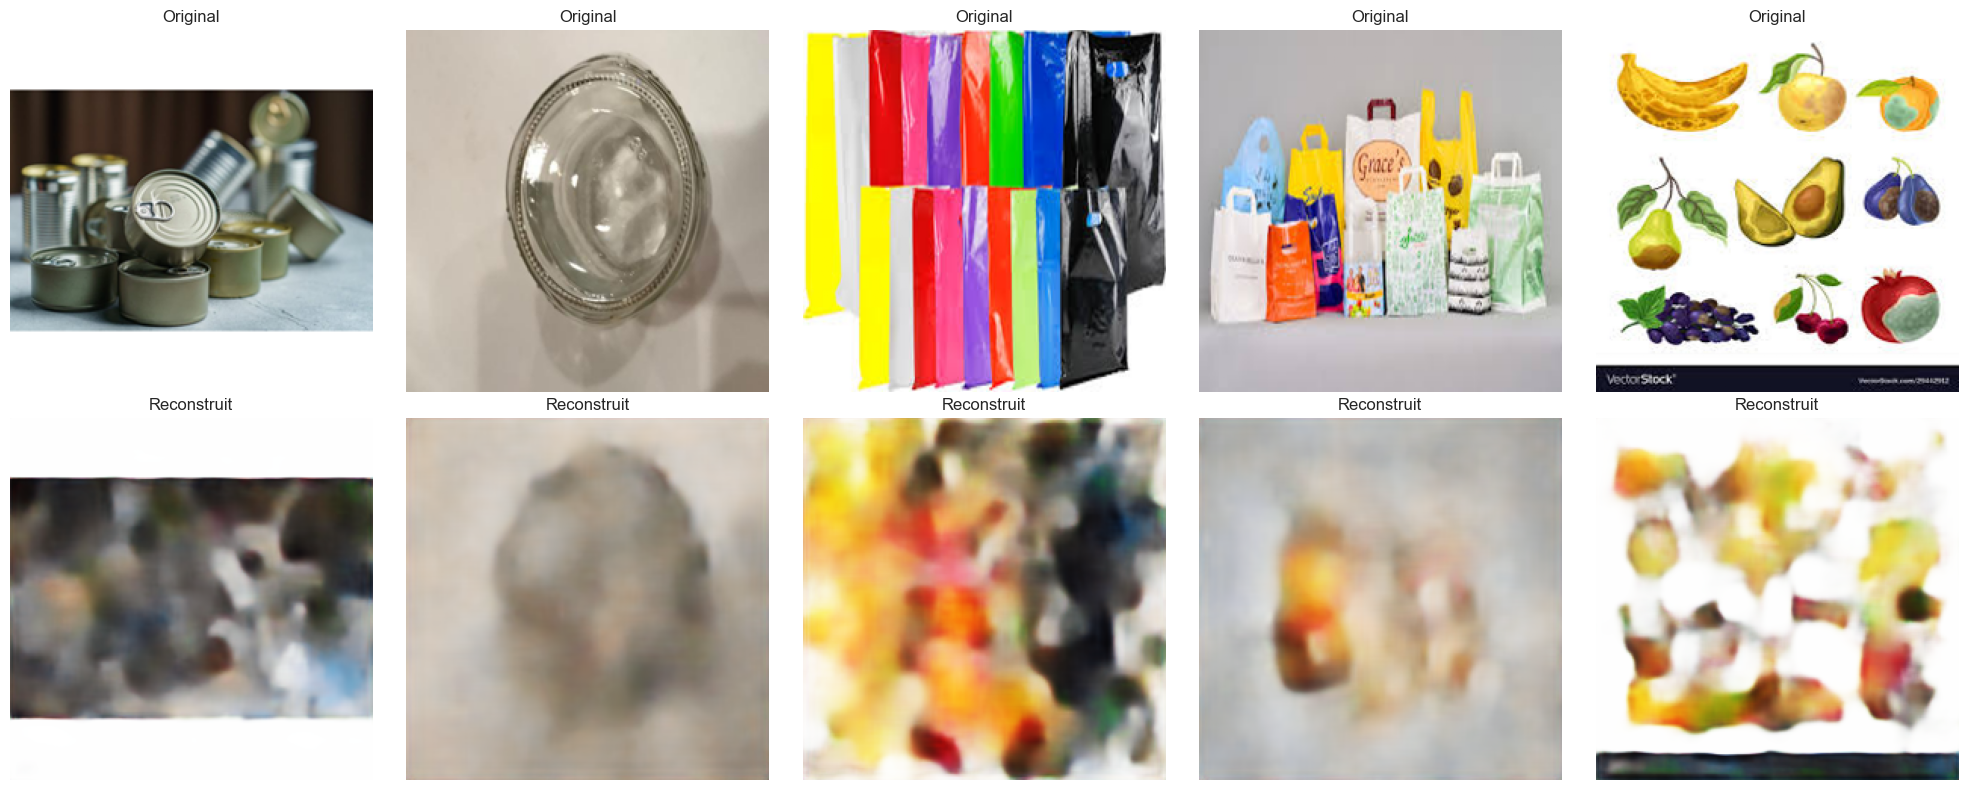

In [110]:
n = 5
plt.figure(figsize=(20, 8))
for i in range(n):
    plt.subplot(2, n, i + 1)
    plt.imshow(np.clip(img[i], 0, 1))
    plt.axis("off")
    plt.title("Original")

    plt.subplot(2, n, n + i + 1)
    plt.imshow(np.clip(pred[i], 0, 1))
    plt.axis("off")
    plt.title("Reconstruit")
plt.savefig("test_auto.png")
plt.tight_layout()
plt.show()


In [16]:
df_anomalie = outils.Load_data.load_object("detect_anomalie.zip")

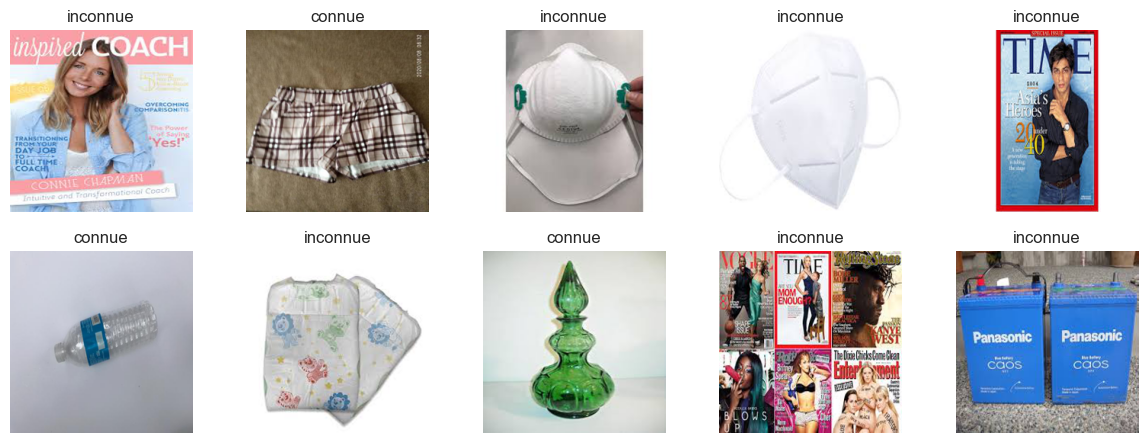

In [18]:
df_anomalie.plot(view_code=True)

In [20]:
df_anomalie.encodage()

In [22]:
(X_test_an, y_test_an), (_,_) = df_anomalie.create_data(test_size=0.0000000000001)

In [19]:
np.unique(y_test_an,return_counts=True)

(array([0, 1]), array([1999, 2000], dtype=int64))

In [24]:
(X_test_an, y_test_an), (_,_) = df_anomalie.create_data(test_size=0.0000000000001)

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import (
    confusion_matrix, roc_curve,
    precision_recall_curve, classification_report, roc_auc_score
)
import seaborn as sns
import pandas as pd

def detect_anomalies(autoencoder, x_data, y_true, thresholds, batch_size=32):
    """
    Détection d'anomalies complète avec visualisations et rapport détaillé.
    - Calcule les erreurs de reconstruction de manière itérative (optimisée pour faible RAM)
    - Évalue les performances selon plusieurs seuils
    - Trace les courbes des métriques + du nombre d’anomalies détectées
    - Affiche la matrice de confusion (en %) avec labels 'Normal' et 'Anormal'
    - Affiche un rapport global de classification
    """

    # ---------------------------
    # Étape 1 : Calcul des erreurs
    # ---------------------------
    print("Calcul des erreurs de reconstruction...")
    n = len(x_data)
    errors = []
    for i in tqdm(range(0, n, batch_size)):
        batch = x_data[i:i + batch_size]
        recon = autoencoder.predict(batch, verbose=0)
        batch_errors = np.mean(np.square(batch - recon), axis=(1, 2, 3))
        errors.extend(batch_errors)
    errors = np.array(errors)

    # ---------------------------
    # Étape 2 : Histogramme des erreurs
    # ---------------------------
    plt.figure(figsize=(8, 5))
    plt.hist(errors[y_true == 0], bins=40, alpha=0.7, label="Normales")
    plt.hist(errors[y_true == 1], bins=40, alpha=0.7, label="Anomalies")
    plt.xlabel("Erreur de reconstruction")
    plt.ylabel("Fréquence")
    plt.title("Distribution des erreurs de reconstruction")
    plt.legend()
    plt.grid(True)
    plt.show()

    # ---------------------------
    # Étape 3 : Calcul des métriques pour chaque seuil
    # ---------------------------
    results = {}
    n_normals_detected, n_anomalies_detected = [], []

    for t in thresholds:
        y_pred = (errors > t).astype(int)
        cm = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = cm.ravel()

        acc = (tp + tn) / (tp + tn + fp + fn + 1e-8)
        prec = tp / (tp + fp + 1e-8)
        rec = tp / (tp + fn + 1e-8)
        f1 = 2 * prec * rec / (prec + rec + 1e-8)
        results[t] = {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1}

        n_normals_detected.append((y_pred == 0).sum())
        n_anomalies_detected.append((y_pred == 1).sum())

    # Convertir en DataFrame pour analyse
    df_metrics = pd.DataFrame(results).T
    df_metrics["anomalies_detected"] = n_anomalies_detected
    df_metrics["normals_detected"] = n_normals_detected

    # ---------------------------
    # Étape 4 : Tracer les métriques et détections
    # ---------------------------
    fig, axes = plt.subplots(1, 2, figsize=(16,6))

    # (a) Nombre de détections
    axes[0].plot(thresholds, df_metrics["normals_detected"], label="Normales détectées")
    axes[0].plot(thresholds, df_metrics["anomalies_detected"], label="Anomalies détectées")
    axes[0].set_title("Évolution du nombre de détections")
    axes[0].set_xlabel("Seuil d'anomalie")
    axes[0].set_ylabel("Nombre d'échantillons")
    axes[0].legend()
    axes[0].grid(True)
    
    # (b) Évolution des métriques
    axes[1].plot(thresholds, df_metrics["accuracy"], label="Exactitude")
    axes[1].plot(thresholds, df_metrics["precision"], label="Précision")
    axes[1].plot(thresholds, df_metrics["recall"], label="Rappel")
    axes[1].plot(thresholds, df_metrics["f1"], label="F1-score")
    axes[1].set_title("Évolution des métriques selon le seuil")
    axes[1].set_xlabel("Seuil d'anomalie")
    axes[1].set_ylabel("Valeur métrique")
    axes[1].legend()
    axes[1].grid(True)

    plt.savefig("auto_metrix.png")
    plt.tight_layout()
    plt.show()

    # ---------------------------
    # Étape 5 : Courbes ROC et PR
    # ---------------------------
    fpr, tpr, _ = roc_curve(y_true, errors)
    precision, recall, _ = precision_recall_curve(y_true, errors)
    auc_score = roc_auc_score(y_true, errors)

    plt.figure(figsize=(16, 6))
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f"AUC = {auc_score:.3f}")
    plt.xlabel("Taux de faux positifs (FPR)")
    plt.ylabel("Taux de vrais positifs (TPR)")
    plt.title("Courbe ROC")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(recall, precision)
    plt.xlabel("Rappel")
    plt.ylabel("Précision")
    plt.title("Courbe Précision-Rappel")
    plt.grid(True)
    plt.show()

    # ---------------------------
    # Étape 6 : Seuil optimal + rapport complet
    # ---------------------------
    best_t = df_metrics["f1"].idxmax()
    print(f"\n Seuil optimal (F1 max) = {best_t:.5f}\n")
    print("Métriques associées :")
    print(df_metrics.loc[best_t].to_string(), "\n")

    y_pred_best = (errors > best_t).astype(int)

    # Matrice de confusion (avec labels et pourcentages)
    cm_best = confusion_matrix(y_true, y_pred_best)
    cm_percent = cm_best.astype('float') / cm_best.sum(axis=1)[:, np.newaxis]

    labels = ["Normal", "Anormal"]
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_percent, annot=True, fmt=".2%", cmap="Blues", cbar=False,
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Prédiction")
    plt.ylabel("Vérité terrain")
    plt.title("Matrice de confusion - Seuil optimal")
    plt.savefig("matrix_auto.png")
    plt.show()

    print("Rapport de classification :")
    print(classification_report(y_true, y_pred_best, target_names=labels, digits=3))

    return errors, df_metrics, best_t


🧠 Calcul des erreurs de reconstruction...


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [03:26<00:00,  1.21it/s]


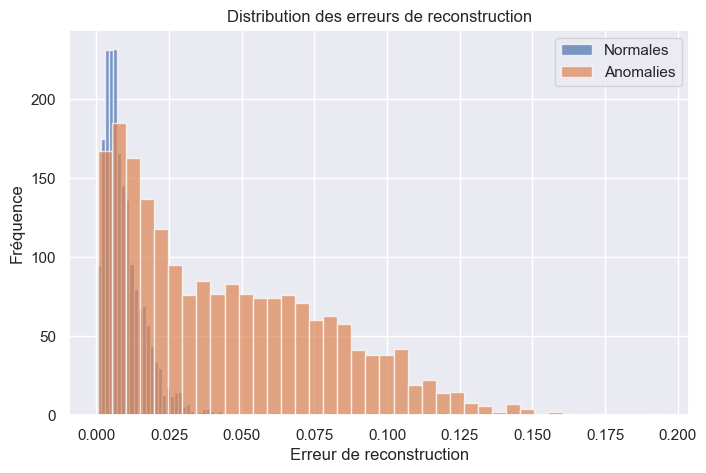

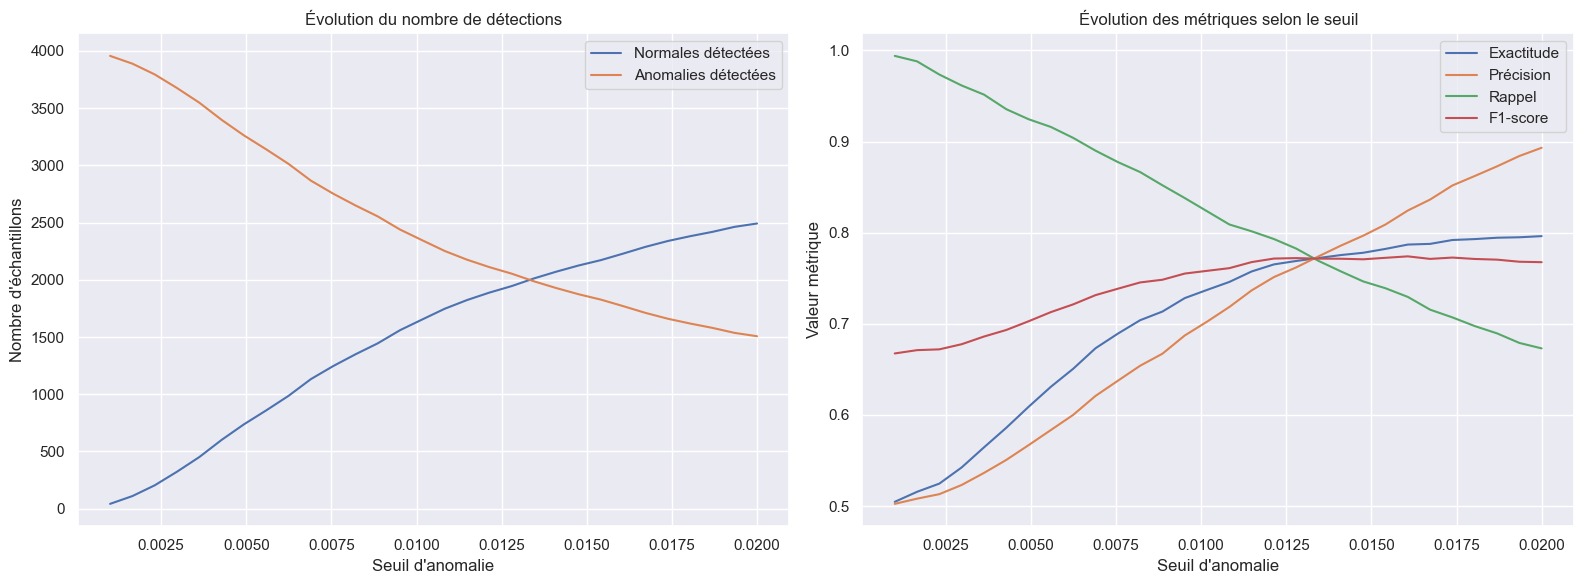

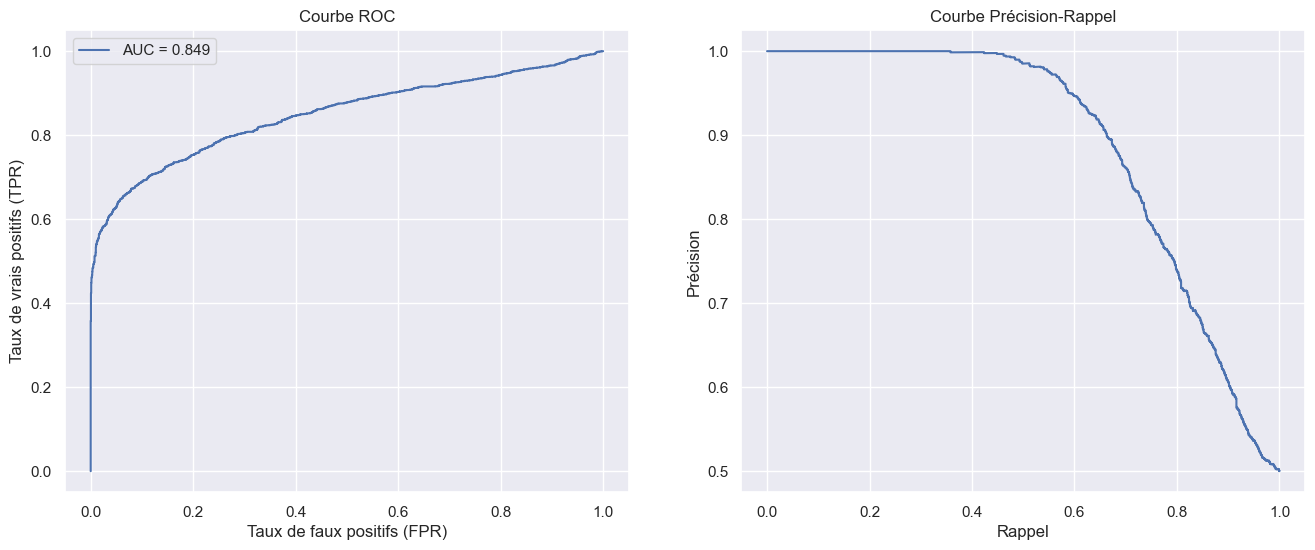


✅ Seuil optimal (F1 max) = 0.01607

Métriques associées :
accuracy                 0.786947
precision                0.824294
recall                   0.729500
f1                       0.774005
anomalies_detected    1770.000000
normals_detected      2229.000000 



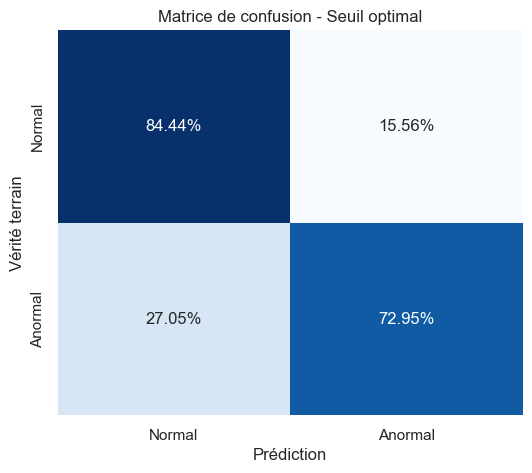

📊 Rapport de classification :
              precision    recall  f1-score   support

      Normal      0.757     0.844     0.798      1999
     Anormal      0.824     0.730     0.774      2000

    accuracy                          0.787      3999
   macro avg      0.791     0.787     0.786      3999
weighted avg      0.791     0.787     0.786      3999



In [56]:
thresholds = np.linspace(0.001, 0.02, 30)
errors, df_metrics, best_t = detect_anomalies_complete_v2(model1, X_test_an, y_test_an, thresholds, batch_size=16)